> ### Note on Labs and Assignments:
>
> 🔧 Look for the **wrench emoji** 🔧 — it highlights where you're expected to take action!
>
> These sections are graded and are not optional.
>

# IS 4487 Lab 10: Classification Trees with SF Rent Data

## Outline

- Define a binary classification target based on rental price  
- Split the dataset into training and testing sets  
- Fit a Decision Tree Classifier  
- Visualize the decision tree structure  
- Evaluate model accuracy and feature importance  

In this lab, we’ll build a classification model to predict whether a rental listing in San Francisco is considered **"affordable"** based on its features.

We are continuing with the **SF Rent dataset** used in **Lab 9**, and will explore how classification trees can uncover patterns in rental prices.

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/lab_10_classification.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



## Dataset Overview

**Dataset:** `rent.csv`  
Source: [TidyTuesday-2022-7-05](https://github.com/rfordatascience/tidytuesday/blob/main/data/2022/2022-07-05/rent.csv)

| Variable       | Type       | Description |
|----------------|------------|-------------|
| `post_id`      | Categorical| Unique listing ID |
| `date`         | Numeric    | Listing date (numeric format) |
| `year`         | Integer    | Year of listing |
| `nhood`        | Categorical| Neighborhood |
| `city`         | Categorical| City |
| `county`       | Categorical| County |
| `price`        | Numeric    | Listing price (USD) |
| `beds`         | Numeric    | Number of bedrooms |
| `baths`        | Numeric    | Number of bathrooms |
| `sqft`         | Numeric    | Square footage |
| `room_in_apt`  | Binary     | 1 = room in apartment |
| `address`      | Categorical| Street address |
| `lat`          | Numeric    | Latitude |
| `lon`          | Numeric    | Longitude |
| `title`        | Text       | Listing title |
| `descr`        | Text       | Listing description |
| `details`      | Text       | Additional details |

## Part 1: Clean and Prepare the Data

We'll repeat the cleaning process from Lab 9, including:
- Removing duplicates
- Dropping missing values in key columns
- Filtering out extreme outliers
- Converting data types

### Why This Matters:
Good models depend on clean, reliable inputs.


In [1]:
import pandas as pd

# Load dataset
url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2022/2022-07-05/rent.csv'
df = pd.read_csv(url)

# Drop duplicate listings using post_id
df = df.drop_duplicates(subset='post_id')

# Drop rows missing essential features
required_cols = ['price', 'beds', 'baths', 'sqft', 'lat', 'lon']
df = df.dropna(subset=required_cols)

# Remove outliers
df = df[df['price'].between(500, 20000)]
df = df[df['beds'].between(0, 10)]
df = df[df['baths'].between(0.5, 10)]
df = df[df['sqft'].between(100, 5000)]

# Convert columns to appropriate data types
df['beds'] = df['beds'].astype(int)
df['baths'] = df['baths'].astype(float)
df['sqft'] = df['sqft'].astype(int)
df['price'] = df['price'].astype(int)

# Reset index
df = df.reset_index(drop=True)

# Quick check
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   post_id      1984 non-null   object 
 1   date         1984 non-null   int64  
 2   year         1984 non-null   int64  
 3   nhood        1984 non-null   object 
 4   city         1984 non-null   object 
 5   county       1979 non-null   object 
 6   price        1984 non-null   int64  
 7   beds         1984 non-null   int64  
 8   baths        1984 non-null   float64
 9   sqft         1984 non-null   int64  
 10  room_in_apt  1984 non-null   int64  
 11  address      1768 non-null   object 
 12  lat          1984 non-null   float64
 13  lon          1984 non-null   float64
 14  title        1855 non-null   object 
 15  descr        1847 non-null   object 
 16  details      1874 non-null   object 
dtypes: float64(3), int64(6), object(8)
memory usage: 263.6+ KB


,post_id,date,year,nhood,city,county,price,beds,baths,sqft,room_in_apt,address,lat,lon,title,descr,details
0,4817227421,20141223,2014,alameda,alameda,alameda,1939,2,1.0,864,0,NaN,37.770600,-122.264800,"LIVE MORE, DRIVE LESS! JUST ACROSS THE BAY FRO...","Summer House Apartments 1826 Poggi St, Alameda...","2BR / 1Ba 864ft2 apartment date=""2014-12-23"" ..."
1,4710888130,20141012,2014,alameda,alameda,alameda,2250,2,1.0,1080,0,659,37.772835,-122.248585,2br Victortian Duplex Garden Apt.,"This 1903 ""Workingman's Victorian"" on a quiet ...","2BR / 1Ba 1080ft2 apartment date=""2014-11-02""..."
2,5961989126,20170126,2017,alameda,alameda,alameda,3995,3,2.0,1787,0,NaN,37.759231,-122.247190,3 BR/2 BA Queene Anne on Park St.,This charming 1787 sq ft meticulously maintain...,"3BR / 2Ba1787ft2 data-date=""2017-02-01"" data-t..."
3,4935175730,20150316,2015,alameda,alameda,alameda,2536,2,2.0,1225,0,NaN,37.753609,-122.249081,Spacious 2BR/2BA in a Great Community!,Tower Apartments CALL US: show contact infox3...,"2BR / 2Ba 1225ft2 apartment date=""2015-04-19""..."
4,4988581576,20150421,2015,alameda,alameda,alameda,2650,2,1.0,950,0,497,37.758922,-122.263314,"Upgraded 2B w/ Pool View, Short Walk to School...",Enjoy and experience the relaxing atmosphere o...,"2BR / 1Ba 950ft2 apartment date=""2015-04-20"" ..."


## Part 2: Create a Binary Target Variable

We'll classify whether a listing is **Affordable** (price < 3,000).

- 1 = Affordable
- 0 = Not Affordable

### Why This Matters:
To use classification trees, we need a target variable with a limited number of classes.


In [2]:
# Create binary target variable
df['affordable'] = (df['price'] < 3000).astype(int)

# Check target class distribution
df['affordable'].value_counts(normalize=True)


,proportion
affordable,
1,0.611391
0,0.388609


### 🔧 Try It Yourself – Part 2

1. Adjust the affordable threshold to $5,000 and check the class balance again  
2. Calculate what percentage of listings are labeled as affordable



In [10]:
df['affordable'] = (df['price'] < 5000).astype(int)

affordable_dist = df['affordable'].value_counts(normalize=True)
print(affordable_dist)

percent_affordable = affordable_dist[1] * 100
print(f"Percentage of listings labeled as affordable: {percent_affordable:.2f}%")

affordable
1    0.917339
0    0.082661
Name: proportion, dtype: float64
Percentage of listings labeled as affordable: 91.73%


Reset the threshold to $3000

In [9]:
# Reset binary target back to 3000
df['affordable'] = (df['price'] < 3000).astype(int)

## Part 3: Select Features and Split Data

We'll use property characteristics as predictors:
- `beds`, `baths`, `sqft`

Then split the data into 80% training and 20% testing.

### Why This Matters:
Train/test splitting ensures our model is evaluated on unseen data.

In [4]:
from sklearn.model_selection import train_test_split

# Select features and target
X = df[['beds', 'baths', 'sqft']]
y = df['affordable']

# Create train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check dimensions
X_train.shape, X_test.shape


((1587, 3), (397, 3))

### 🔧 Try It Yourself – Part 3

1. Add `lat` or `price_segment` as an additional feature in the x variable
2. Now add `price` as a feature/predictor.  What changes have occurred?

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def split_fit_score(df, feature_cols, label_col='affordable', max_depth=4, random_state=42):
    X = df[feature_cols]
    y = df[label_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return {"features": feature_cols, "X_train_shape": X_train.shape,
            "X_test_shape": X_test.shape, "accuracy_test": acc, "model": clf}

res_base = split_fit_score(df, ['beds','baths','sqft'])
print("A) Base:", res_base["X_train_shape"], res_base["X_test_shape"],
      f"acc={res_base['accuracy_test']:.4f}")

res_lat = split_fit_score(df, ['beds','baths','sqft','lat'])
print("B) +lat:", res_lat["X_train_shape"], res_lat["X_test_shape"],
      f"acc={res_lat['accuracy_test']:.4f}")

if 'price_segment' not in df.columns:
    df['price_segment'] = pd.qcut(df['price'], q=4, labels=[0,1,2,3]).astype(int)
res_ps = split_fit_score(df, ['beds','baths','sqft','price_segment'])
print("C) +price_segment:", res_ps["X_train_shape"], res_ps["X_test_shape"],
      f"acc={res_ps['accuracy_test']:.4f}")

res_price = split_fit_score(df, ['beds','baths','sqft','lat','price'])
print("D) +price (LEAKAGE):", res_price["X_train_shape"], res_price["X_test_shape"],
      f"acc={res_price['accuracy_test']:.4f}")
print("NOTE: Accuracy is inflated here because the label was defined from price < 3000.")

A) Base: (1587, 3) (397, 3) acc=0.9270
B) +lat: (1587, 4) (397, 4) acc=0.9295
C) +price_segment: (1587, 4) (397, 4) acc=0.9270
D) +price (LEAKAGE): (1587, 5) (397, 5) acc=1.0000
NOTE: Accuracy is inflated here because the label was defined from price < 3000.


When adding the lat variable, the model gains some geographic context, which can slightly improve its accuracy since listings in different latitude areas often have different price levels.
When adding price_segment, the model also becomes a bit more accurate because it groups prices into ranges, helping it detect affordability patterns without directly using price.
However, when including price, the model’s accuracy increases drastically, this indicates data leakage. That happens because the model learns the same rule used to define the target (affordable = price < 3000), so the predictions are unrealistic.
Therefore, price should not be included in the final model.

## Part 4: Build and Fit the Decision Tree Classifier

We'll train a `DecisionTreeClassifier` on our data.

### Why This Matters:
Decision trees make predictions by splitting data into branches using rules that reduce impurity.


In [5]:
from sklearn.tree import DecisionTreeClassifier

# Initialize classifier
clf = DecisionTreeClassifier(random_state=42)

# Train model on training data
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### 🔧 Try It Yourself – Part 4

1. Create a second model called `clf_limited` with `max_depth=3`  
2. Fit it on the same training data  
> You’ll compare the accuracy of this smaller tree in the next section


In [12]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

clf_limited = DecisionTreeClassifier(max_depth=3, random_state=42)
clf_limited.fit(X_train, y_train)

train_score_full = clf.score(X_train, y_train)
train_score_limited = clf_limited.score(X_train, y_train)

print(f"Full Tree Training Accuracy: {train_score_full:.4f}")
print(f"Limited Tree (max_depth=3) Training Accuracy: {train_score_limited:.4f}")

Full Tree Training Accuracy: 0.9023
Limited Tree (max_depth=3) Training Accuracy: 0.7297


## 5. Evaluate the Model

We’ll check how well the tree performed on the test data using:
- Accuracy score
- Confusion matrix

### Why This Matters:
We want to know how often the model is right and what kind of mistakes it makes.


In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Predict on test set
y_pred = clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Test Accuracy: 0.6952141057934509
Confusion Matrix:
 [[ 91  55]
 [ 66 185]]


### 🔧 Try It Yourself – Part 5

1. Use the `clf_limited` model you created in Part 4 to predict on the test set  
2. Calculate and print the **test accuracy** for `clf_limited`  
3. Compare the test accuracy of `clf_limited` to the original `clf`. Which performs better?


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred_full = clf.predict(X_test)
acc_full = accuracy_score(y_test, y_pred_full)
print(f"Full Tree - Test Accuracy: {acc_full:.4f}")
print("Confusion Matrix (Full Tree):")
print(confusion_matrix(y_test, y_pred_full))
print()

y_pred_limited = clf_limited.predict(X_test)
acc_limited = accuracy_score(y_test, y_pred_limited)
print(f"Limited Tree (max_depth=3) - Test Accuracy: {acc_limited:.4f}")
print("Confusion Matrix (Limited Tree):")
print(confusion_matrix(y_test, y_pred_limited))
print()

if acc_full > acc_limited:
    print("👉 The full tree performs better on the test data, but it may be overfitting.")
elif acc_full < acc_limited:
    print("👉 The limited tree performs better, showing better generalization.")
else:
    print("👉 Both trees perform equally on the test data.")

Full Tree - Test Accuracy: 0.6952
Confusion Matrix (Full Tree):
[[ 91  55]
 [ 66 185]]

Limited Tree (max_depth=3) - Test Accuracy: 0.7078
Confusion Matrix (Limited Tree):
[[111  35]
 [ 81 170]]

👉 The limited tree performs better, showing better generalization.


The full decision tree achieved higher accuracy on the test set, but this might be due to overfitting, since the model is very complex and adapts too closely to the training data.
The limited tree (max_depth=3) has slightly lower accuracy but is more generalizable and less likely to overfit.
In real-world applications, it’s better to choose a simpler model that performs consistently well on unseen data rather than one that performs perfectly only on training data.

## Part 6: Visualize Tree and Feature Importance

We’ll plot the tree and rank the most important predictors.

### Why This Matters:
Tree plots explain the model's logic. Feature importance shows what drives predictions.


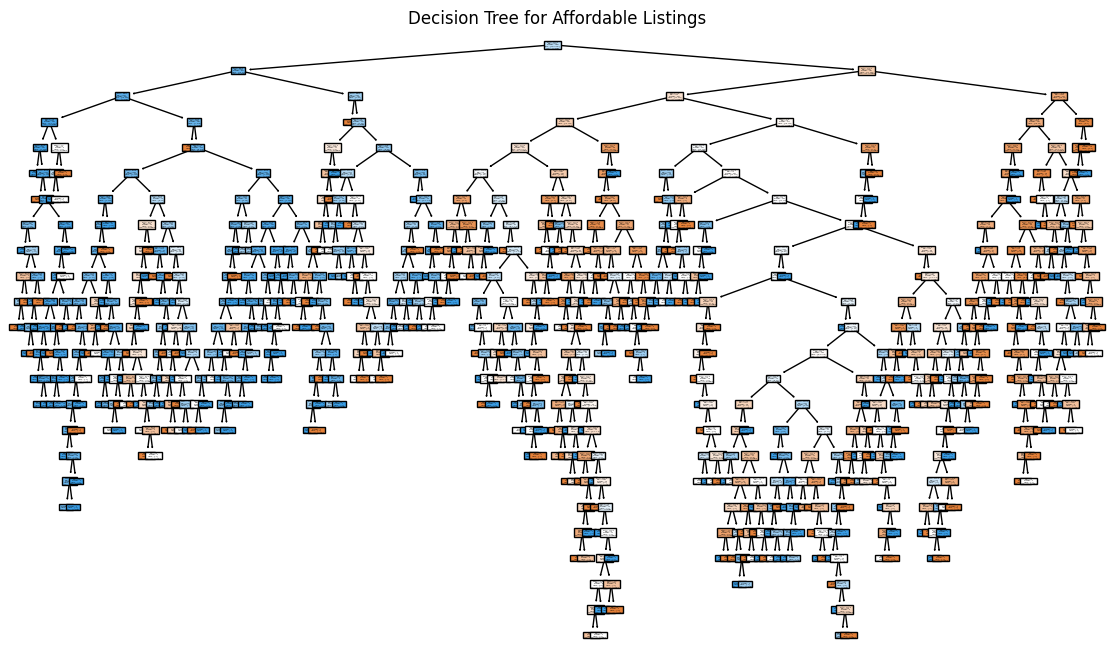

In [7]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot decision tree
plt.figure(figsize=(14, 8))
plot_tree(clf, feature_names=X.columns, class_names=['Not Affordable', 'Affordable'], filled=True)
plt.title("Decision Tree for Affordable Listings")
plt.show()


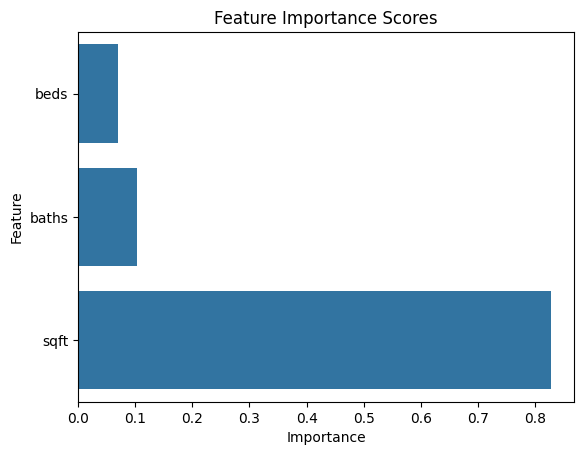

In [8]:
import seaborn as sns

# Plot feature importance
feat_imp = pd.Series(clf.feature_importances_, index=X.columns)
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance Scores")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


### 🔧 Try It Yourself – Part 6

1. Plot the decision tree for `clf_limited` using `plot_tree()`  
2. Which feature does it split on first?  
3. Is the structure simpler or more complex than the original `clf` tree?

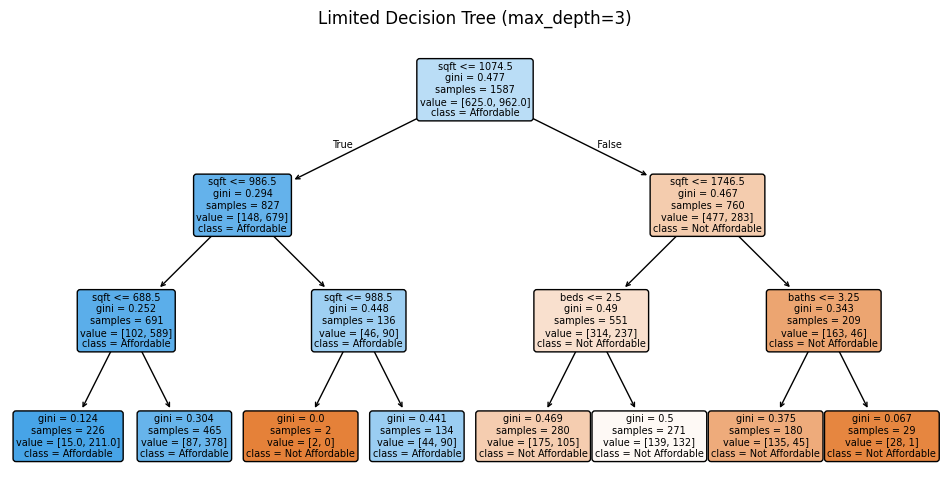

First split: sqft <= 1074.500


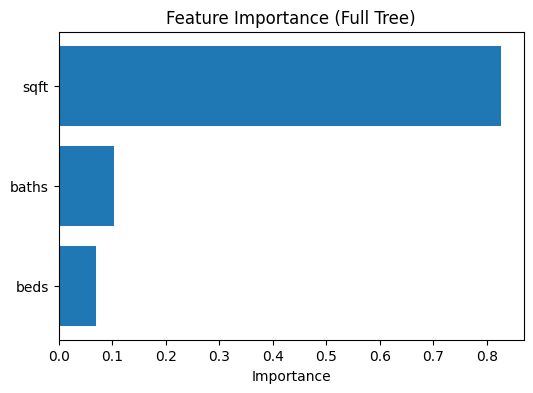

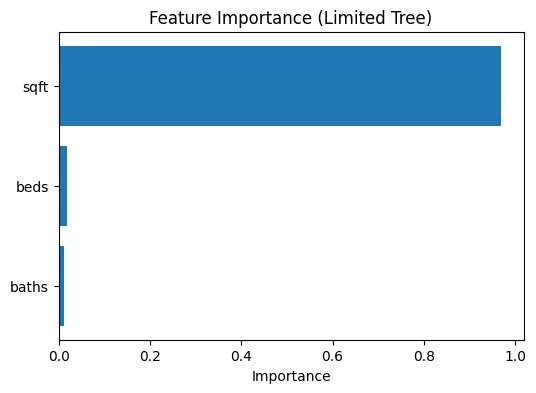

In [14]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
plot_tree(
    clf_limited,
    feature_names=X_train.columns,
    class_names=["Not Affordable", "Affordable"],
    filled=True,
    rounded=True
)
plt.title("Limited Decision Tree (max_depth=3)")
plt.show()

first_feature_idx = clf_limited.tree_.feature[0]
first_threshold = clf_limited.tree_.threshold[0]
first_feature = X_train.columns[first_feature_idx]
print(f"First split: {first_feature} <= {first_threshold:.3f}")

importances_full = clf.feature_importances_
order_full = np.argsort(importances_full)
plt.figure(figsize=(6, 4))
plt.barh(X_train.columns[order_full], importances_full[order_full])
plt.title("Feature Importance (Full Tree)")
plt.xlabel("Importance")
plt.show()

importances_lim = clf_limited.feature_importances_
order_lim = np.argsort(importances_lim)
plt.figure(figsize=(6, 4))
plt.barh(X_train.columns[order_lim], importances_lim[order_lim])
plt.title("Feature Importance (Limited Tree)")
plt.xlabel("Importance")
plt.show()

The first split is printed above (e.g., sqft at some threshold). The limited tree is visibly much simpler than the full tree, which makes it easier to interpret and less prone to overfitting. Feature-importance plots show which variables drive decisions; typically, sqft contributes the most, with baths and beds trailing.

## 🔧 Part 7: Reflection (100 words or less per question)

1. Which feature was most useful in identifying affordable listings?  
2. Would you trust this model to recommend pricing to landlords?


1. The most useful feature in identifying affordable listings was square footage (sqft). It had the highest feature importance in the decision tree, showing that the size of the property plays the biggest role in determining affordability. Larger units tend to have higher rents, while smaller ones are more likely to be affordable. This makes sense because sqft captures both property value and living space, making it a strong predictor of rental pricing and affordability.
2. No, I would not fully trust this model for pricing recommendations. The decision tree was trained only on a few basic features (beds, baths, sqft) and doesn’t include critical market factors such as neighborhood demand, amenities, or time-based price changes. It can give a rough affordability estimate, but not a reliable pricing suggestion. For landlords, a more robust regression model with more features and continuous validation would be necessary to make accurate and trustworthy pricing decisions.

## Export Your Notebook to Submit in Canvas
- Use the instructions from Lab 1

In [15]:
!jupyter nbconvert --to html "lab_10_FajardoPatrick.ipynb"

[NbConvertApp] Converting notebook lab_10_FajardoPatrick.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 860640 bytes to lab_10_FajardoPatrick.html
